In [38]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()


Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-1885264352 seed_offset=0 real_seed=-1885264352
core.init.random: RandomGenerat

In [39]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *

In [40]:
def within_360(ang):
    
    return ang - 360.0*int(ang/360.0)

In [41]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [42]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        if seq2 and ii == (n_residues/2) - 1: continue
            
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})

        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [43]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'linmin_iterated', 1e-6, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [44]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64.11)
        pose.set_torsion(dof_dict[6*ii+1], 176.33)
        pose.set_torsion(dof_dict[6*ii+2], 53.08)
        pose.set_torsion(dof_dict[6*ii+3], -150.17)
        pose.set_torsion(dof_dict[6*ii+4], -71.45)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79.43)
    
    return pose

In [45]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            if key > len(dofs)/2 -2: key += 5
            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
            
            if key > len(dofs)/2 - 2: key += 5 
            temp.set_torsion(dof_dict[key], val)
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result

In [225]:
seq1 = 'ggg'
seq2 = 'ccc'

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner')

In [226]:
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-6, True)
minmover.max_iter(100000)

In [227]:
import itertools

minimum = Pose()

pose.assign(helix_state(pose, dof_dict))
minmover.apply(pose)
minimum.assign(pose)

h = 0.5
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(2/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-1, 1+h, h)
    
for pair in list(itertools.combinations(dof_dict.keys(), 2)):
    
    foo = pair[0]
    bar = pair[1]
    if foo > len(dofs)/2 - 2: foo -= 5
    if bar > len(dofs)/2 - 2: bar -= 5
    
    x = tor_ranges[:, foo]
    y = tor_ranges[:, bar]

    for ii, xx in enumerate(x):
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[bar])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[foo])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0:
        
        hessian[foo, foo] = d2E_dx2[ind, ind]
        
    if hessian[bar, bar] == 0:
        
        hessian[bar, bar] = d2E_dy2[ind, ind]
        
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
pose.assign(minimum)

core.optimization:  norm: 1     158.9996 norm_numeric:     160.3371 cos_theta:  0.9999 log_norm_ratio:    0.0084
core.optimization:  norm: 2     158.9996 norm_numeric:     160.3371 cos_theta:  0.9999 log_norm_ratio:    0.0084
core.optimization:  norm: 3     158.9996 norm_numeric:     160.3372 cos_theta:  0.9999 log_norm_ratio:    0.0084
core.optimization:  norm: 4     158.9996 norm_numeric:     160.3376 cos_theta:  0.9999 log_norm_ratio:    0.0084
core.optimization:  norm: 5     158.9996 norm_numeric:     160.3394 cos_theta:  0.9999 log_norm_ratio:    0.0084
core.optimization:  norm: 1       7.5258 norm_numeric:       6.3903 cos_theta:  0.9704 log_norm_ratio:   -0.1636
core.optimization:  norm: 2       7.5258 norm_numeric:       6.3903 cos_theta:  0.9704 log_norm_ratio:   -0.1636
core.optimization:  norm: 3       7.5258 norm_numeric:       6.3903 cos_theta:  0.9704 log_norm_ratio:   -0.1636
core.optimization:  norm: 4       7.5258 norm_numeric:       6.3903 cos_theta:  0.9704 log_norm_

core.optimization:  norm: 4       0.6930 norm_numeric:       1.1970 cos_theta:  0.7838 log_norm_ratio:    0.5465
core.optimization:  norm: 5       0.6930 norm_numeric:       1.1969 cos_theta:  0.7837 log_norm_ratio:    0.5464
core.optimization:  norm: 1       0.4363 norm_numeric:       0.9493 cos_theta:  0.5678 log_norm_ratio:    0.7775
core.optimization:  norm: 2       0.4363 norm_numeric:       0.9493 cos_theta:  0.5678 log_norm_ratio:    0.7775
core.optimization:  norm: 3       0.4363 norm_numeric:       0.9493 cos_theta:  0.5678 log_norm_ratio:    0.7775
core.optimization:  norm: 4       0.4363 norm_numeric:       0.9492 cos_theta:  0.5678 log_norm_ratio:    0.7774
core.optimization:  norm: 5       0.4363 norm_numeric:       0.9486 cos_theta:  0.5678 log_norm_ratio:    0.7768
core.optimization:  norm: 1       0.5105 norm_numeric:       0.6021 cos_theta: -0.0046 log_norm_ratio:    0.1651
core.optimization:  norm: 2       0.5105 norm_numeric:       0.6021 cos_theta: -0.0046 log_norm_

In [228]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)

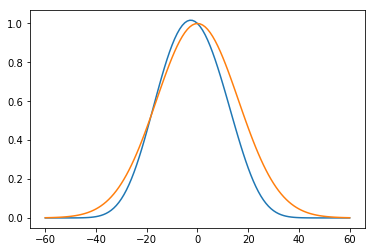

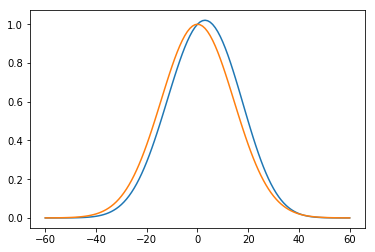

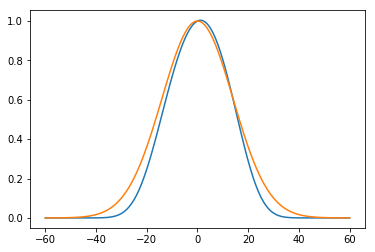

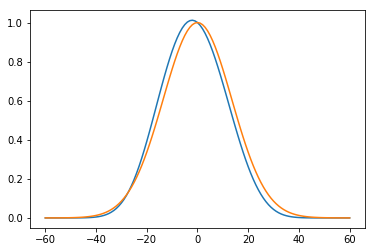

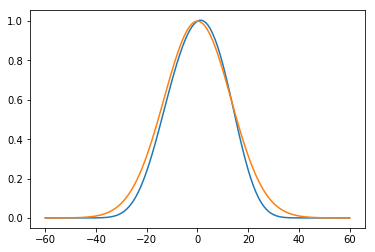

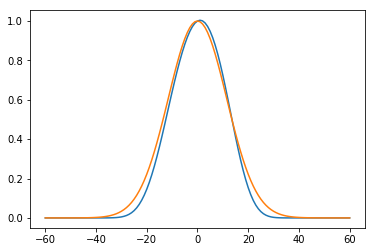

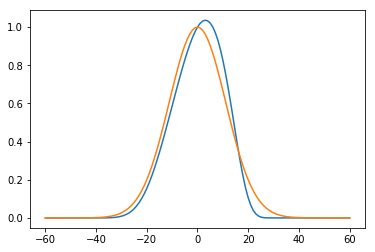

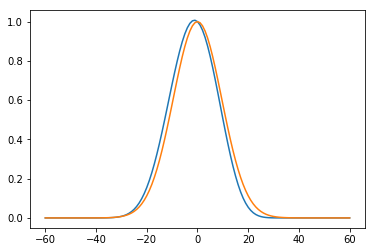

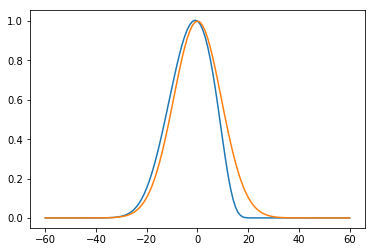

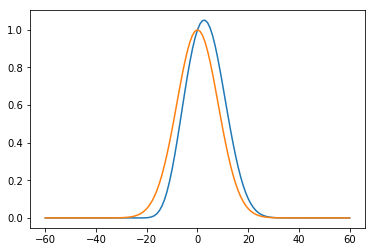

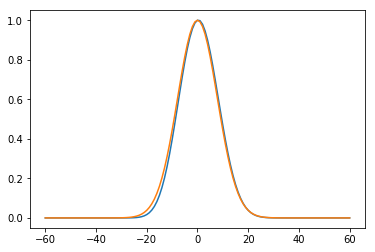

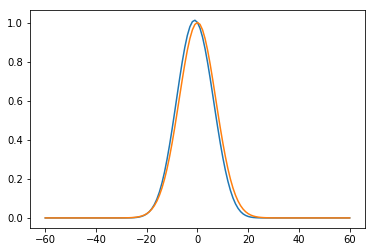

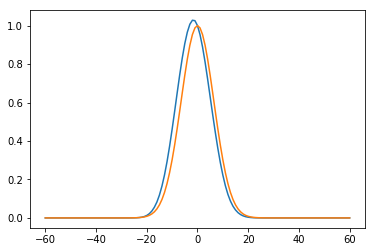

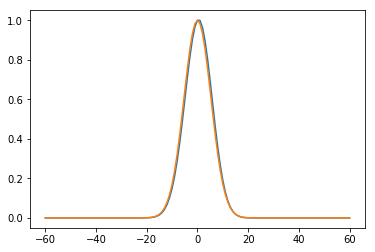

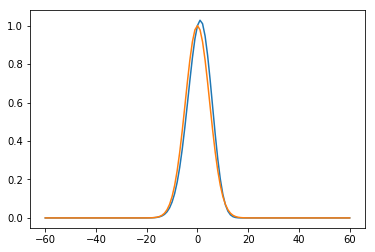

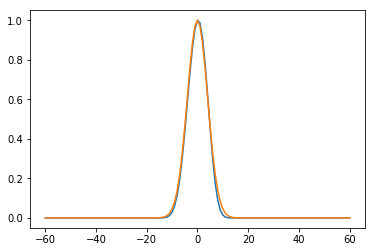

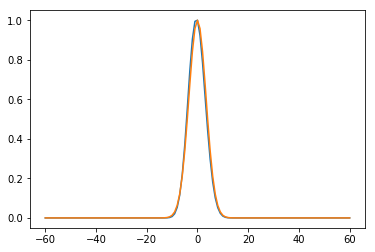

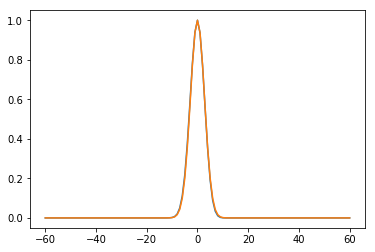

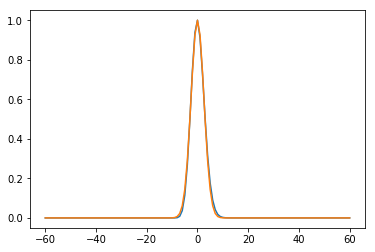

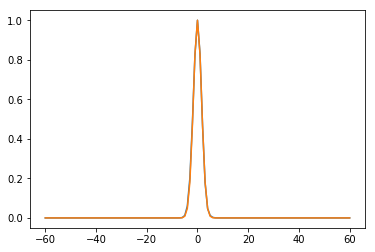

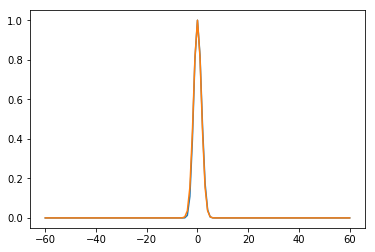

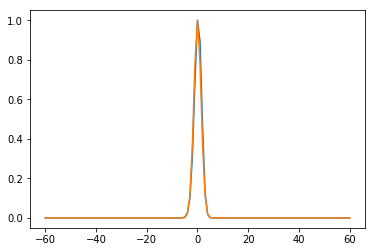

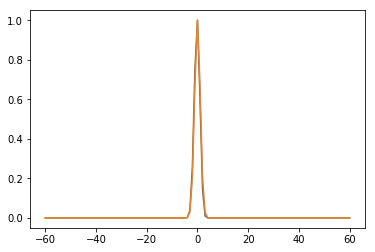

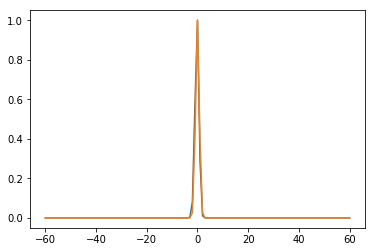

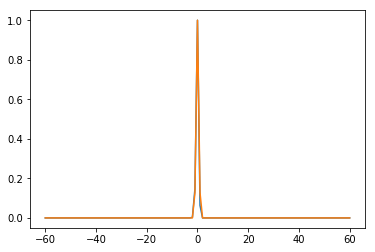

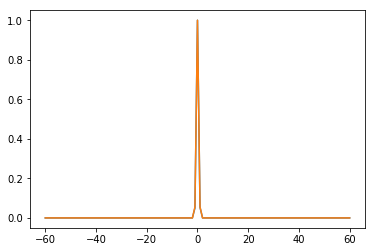

In [229]:
import scipy.integrate

pose.assign(minimum)
kT = 1.0

for kk in range(0,len(w)):

        
    K = w[kk]
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            if jj > len(dofs)/2 - 2: jj += 5
            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)

    np.array(bar) 
    pose.assign(minimum)
    plt.figure()
    plt.plot(h, np.exp(-np.array(bar)))
   
    plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    

In [230]:
from scipy.special import *
pose.assign(minimum)
Z_harm = 1
Z_scan = 1
for ii, K in enumerate(w):

    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 1)
    
    sig = min(2*np.pi/3, 6*np.sqrt(kT/K))
    
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    pose.assign(minimum)
    
    print Z_i, Z_j

0.703680264383 0.514100352293
0.626289155024 0.730423347037
0.610790091849 0.565970957076
0.590688602172 0.518989593931
0.574625964324 0.539704834552
0.502844003015 0.484497499506
0.485985926037 0.508312500814
0.41763023383 0.366490104575
0.410261025931 0.305833535263
0.355901904734 0.468179282888
0.3418694705 0.35319809358
0.315160444236 0.278293902486
0.282053257475 0.241264362416
0.232131139678 0.245825633533
0.208354156691 0.23792062968
0.175508327384 0.170103497937
0.148598679611 0.137400077821
0.121756622555 0.120233012757
0.110883528696 0.114987256245
0.070808925421 0.0712050736437
0.0676800002093 0.0699837103093
0.062383631279 0.0699323436675
0.048988109824 0.0437342345214
0.0322758845759 0.0279661825891
0.0215036190564 0.0196684087594
0.0181161772368 0.0193414608448


In [231]:
print (np.log(Z_harm) + np.log((2*np.pi/3)**len(w))), (np.log(Z_scan) + kT*np.log((2*np.pi/3)**len(w)))

-24.26775827 -25.1097253463
